In [56]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import matplotlib.pyplot as plt
import pprint

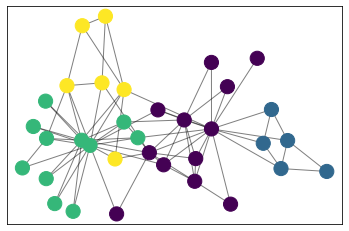

In [62]:
G=nx.Graph()
gr=pd.read_csv('karate.csv')
#gr=pd.read_csv('dolphin.csv')
#gr=pd.read_csv('football.csv')
edge=[(gr['Source'][i],gr['Destination'][i]) for i in range(0,len(gr['Source']))]
G.add_edges_from(edge)
node=max([max(x[0],x[1]) for x in edge])
# compute the best partition
# partition contains color of each node
partition = community_louvain.best_partition(G)

# visualization of clusters
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=200,cmap=cmap, node_color=list(partition.values()),)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [63]:
# Generating gateEdges
# gateEdges contains edges--> [(a,b),(b,c)]
gateEdges=[]
for x in edge:
    if(partition[x[0]]!=partition[x[1]]):
        gateEdges.append(x)

# Generating gate nodes 
gateNodesDict={}

for tup in gateEdges:
    gateNodesDict[tup[0]]=1
    gateNodesDict[tup[1]]=1

gateNodesList=list(gateNodesDict.keys())

print("Gateway graph nodes:",gateNodesList)
for x in gateNodesList:
    for y in gateNodesList:
        if(x==y or ((x,y) in gateEdges) or ((y,x) in gateEdges)):
            continue
        else:
            if(partition[x]==partition[y]):
                if((x,y) in edge or (y,x) in edge):
                    gateEdges.append((x,y))

Gate graph nodes: [5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]


In [99]:
# Gate graph
# This is the gate way graph
gate
tot_g=[]
for i in range(0,500):
    tot_g.append(nx.Graph())

for k in range(0,500):
    tot_g[k].add_nodes_from(gateNodesList)
    for i in range(0,len(gateEdges)):
        tot_g[k].add_edge(gateEdges[i][0],gateEdges[i][1],weight=round(random.uniform(0,1),2))

In [102]:
#BCS Score
def BCS(G,nodes):
    BCS_=[0]*(nodes+1)
    for i in G:
        x=(nx.betweenness_centrality(i,weight='weight'))
        #print(x)
        for j in x:
            BCS_[j]+=(1/10)*x[j]
    #BCS_=[round(i,3) for i in BCS_]
    return BCS_
BCSSS=BCS(tot_g,max([max(a[0],a[1]) for a in gateEdges]))
BCS_value={}
for i in range(1,max([max(a[0],a[1]) for a in gateEdges])+1):
    BCS_value[i]=BCSSS[i]
BCS_value=(sorted(BCS_value.items(), key=lambda x: x[1],reverse=True))
print(BCS_value)

[(1, 22.77788671023968), (34, 16.47407407407408), (3, 11.997794117647057), (33, 8.292973856209137), (9, 5.638970588235284), (2, 4.841748366013064), (32, 4.79471677559912), (14, 4.178976034858381), (31, 2.9035130718954196), (20, 2.6905228758169897), (24, 2.4858660130718904), (11, 2.0647058823529374), (5, 1.9824074074074036), (7, 1.923148148148145), (6, 1.8136437908496705), (28, 1.7485021786492343), (29, 1.3690904139433535), (30, 1.1276960784313712), (10, 0.46535947712418274), (4, 0), (8, 0), (12, 0), (13, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (21, 0), (22, 0), (23, 0), (25, 0), (26, 0), (27, 0)]


In [103]:
# Model selection - diffusion time
model = ep.SIModel(G)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.03)
cfg.add_model_parameter("fraction_infected", 1/max([max(x[0],x[1]) for x in edge]))
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(200)

#Mapping diffusion_time_to_each_node
time_of_diffusion={}
for i in range(1,node+1):
    time_of_diffusion[i]=-1
for i in iterations:
    for j in i['status']:
        if(i['status'][j]==1):
            time_of_diffusion[j]=i['iteration']

100%|██████████| 200/200 [00:00<00:00, 3565.36it/s]


In [104]:
print(time_of_diffusion)

{1: 4, 2: 18, 3: 7, 4: 25, 5: 36, 6: 28, 7: 22, 8: 51, 9: 3, 10: 29, 11: 15, 12: 87, 13: 28, 14: 7, 15: 20, 16: 17, 17: 39, 18: 64, 19: 16, 20: 50, 21: 19, 22: 7, 23: 13, 24: 20, 25: 36, 26: 23, 27: 40, 28: 27, 29: 17, 30: 17, 31: 0, 32: 12, 33: 6, 34: 14}


In [105]:
sensor_nodes=[BCS_value[i][0] for i in range(0,3)]
print(sensor_nodes)
print(gateNodesList)

[1, 34, 3]
[5, 1, 6, 7, 9, 3, 11, 28, 29, 30, 24, 31, 2, 32, 33, 34, 10, 14, 20]


In [106]:
delta_t=[]
min_v=min([time_of_diffusion[i] for i in sensor_nodes])
min_n=-1
for i in sensor_nodes:
    if(time_of_diffusion[i]==min_v):
        min_n=i
        break
delta_t=[(i,abs(time_of_diffusion[i]-min_v)) for i in sensor_nodes if(i!=min_n)]
print(delta_t)

[(34, 10), (3, 3)]
